# Figure 4

Still a draft. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import datetime as dt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from scipy import stats
from dask.distributed import Client

In [2]:
# for gadi_jupyter
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33499 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33499/status,
Dashboard: /proxy/33499/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45027,Workers: 4
Dashboard: /proxy/33499/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:38029,Total threads: 4
Dashboard: /proxy/38037/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:44219,


In [4]:
client

Client Scheduler: tcp://127.0.0.1:40029 Dashboard: /proxy/8787/status,Cluster Workers: 2 Cores: 24 Memory: 96.00 GiB


In [3]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'processed_eke/'

In [4]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [5]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
        
    return cor, sig, Neff

# Load EKE Climatology File

In [6]:
EKEDir = 'processed_eke/'
climfilename = HardDisk+EKEDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE.mean('month').fillna(0)

## Compute variance ratios from saved results

In [7]:
def PlotThisBox(desc, lon1, lon2, lat1, lat2, ax_map, ax_ts, ax_lag, col):

    ## Other things to set
    nfiles = 50
    nn=0
    start = dt.datetime(1980,1,1) ## start time for plotting
    end = dt.datetime(2014,12,31)

    ## Add lines to show our region of interest on the map
    ax_map.plot([lon1, lon1],[lat1,lat2], color=col,linewidth=2,transform=ccrs.PlateCarree())
    ax_map.plot([lon2, lon2],[lat1,lat2], color=col,linewidth=2,transform=ccrs.PlateCarree())
    ax_map.plot(np.arange(lon1,lon2+1),lat1*np.ones(lon2+1-lon1),
            color=col,linewidth=2,transform=ccrs.PlateCarree())
    ax_map.plot(np.arange(lon1,lon2+1),lat2*np.ones(lon2+1-lon1),
            color=col,linewidth=2,transform=ccrs.PlateCarree())
    
    ## plot EKE
    eke_results = []
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EKEDir+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat').load()
        eke_clim = eke.groupby('time.month').mean('time')
        eke_deseas = (eke.groupby('time.month') - eke_clim).load()
        
        #eke_rolling = eke.rolling(time=12,center=True).mean().load()
        eke_deseas.rolling(time=4,center=True).mean().plot(ax=ax_ts,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
        result = {'ii': ii,'eke': eke}
        eke_results.append(result)
    
        if ii==1:
            eke_sum_deseas = eke_deseas
        else:
            eke_sum_deseas = eke_sum_deseas + eke_deseas
                        
    eke_sum_deseas = eke_sum_deseas.load()/nn
    eke_sum_deseas.rolling(time=4,center=True).mean().plot(ax=ax_ts,color=col,linewidth=2)
    ax_ts.set_xlabel('')
    ax_ts.set_ylabel('EKE (m$^2$/s$^2$)',color=col)
    #ax_eke.set_ylim(ymax=0.013)
    ax_ts.tick_params('y',labelcolor=col)
    ax_ts.set_xlim([start,end])

    # Compute variance ratios from saved results
    for result in eke_results:
        ii = result['ii']
        eke = result['eke']
    
        if ii==1:
            eke_var = (eke_deseas - eke_sum_deseas)**2
        else:
            eke_var = eke_var + (eke_deseas - eke_sum_deseas)**2
        
    eke_var = eke_var.load()/nn
    sigma2 = np.var(eke_sum_deseas)  
    epsilon2 = eke_var.mean('time')
    ratio = (epsilon2/(epsilon2+sigma2))
    ax_ts.set_title(desc+': $R_i$ = %0.2f'%ratio.values)
    print(desc+' R_i = %0.2f'%ratio.values)

    ## Axes to plot the wind
    ax_tau=ax_ts.twinx()
    taufilename = HardDisk+'processed_tau/'+'tau_????.nc'
    tau = xr.open_mfdataset(taufilename).tau
    
    tau = tau.sel(lon=slice(lon1,lon2)).sel(lat=slice(lat1,lat2)).mean('lon').mean('lat').load()
    tau_clim = tau.groupby('time.month').mean('time')
    tau_deseas = (tau.groupby('time.month') - tau_clim).load()
    #tau_rolling = tau.rolling(time=12,center=True).mean().load()
    tau_deseas.rolling(time=4,center=True).mean().plot(ax=ax_tau,color='k',linestyle='-',linewidth=1)
    #ax_tau.set_ylim(ymin=0.08)
    ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
    ax_tau.set_xlim([start,end])

    ## Axes to plot lagged correlation
    coef_sum, signif_sum, Neff_sum = pearsoncor(tau_deseas,eke_sum_deseas)
    lag = coef_sum.argmax()
    ax_lag.plot(coef_sum,linewidth=2,color=col,label=desc[4:-1])
    print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif_sum[lag]))
    print('Effective sample size: %d '% Neff_sum[lag])
    T = coef_sum[lag]*Neff_sum[lag]**(0.5)*(1-coef_sum[lag]**2)**(-0.5)
    print('T-statistic at max correlation: %0.2f '% T)
    Tstat = coef_sum*Neff_sum**(0.5)*(1-coef_sum**2)**(-0.5)
    coef_sig = np.where(Tstat>1.96,coef_sum,np.NaN)
    ax_lag.plot(coef_sig,linewidth=6,color=col,alpha=0.4)
    ax_lag.plot(coef_sum,linewidth=1.5,color=col)
    ax_lag.plot(lag,coef_sum[lag],'.',color='k')

## And now plot

(b) Central South Pacific Ocean R_i = 0.80
Correlations: 99 months, 0.05, 0.32
Effective sample size: 317 
T-statistic at max correlation: 0.97 
(d) Southeast Pacific Ocean R_i = 0.38
Correlations: 28 months, 0.25, 0.00
Effective sample size: 285 
T-statistic at max correlation: 4.45 
(e) Southwest Indian Ocean  R_i = 0.93
Correlations: 111 months, 0.15, 0.01
Effective sample size: 343 
T-statistic at max correlation: 2.75 
CPU times: user 14min 26s, sys: 3min 45s, total: 18min 11s
Wall time: 25min 44s


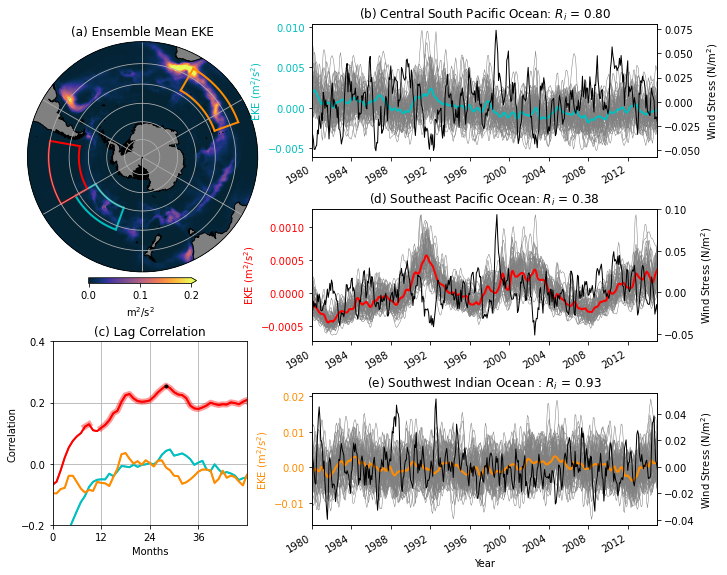

In [8]:
%%time
plt.figure(figsize=(10, 8))

ax_map = plt.axes([0.02, 0.52, 0.35, 0.4],projection=ccrs.SouthPolarStereo())
ax_map.patch.set_facecolor('k')
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax_map.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
ax_map.set_boundary(circle, transform=ax_map.transAxes)
ax_map.add_feature(land_50m)
ax_map.gridlines()
p1 = eke_month.plot(ax=ax_map,cmap=cm.cm.thermal,vmax=0.2,add_colorbar=False,transform=ccrs.PlateCarree())
ax_map.set_title('(a) Ensemble Mean EKE')

# Add colorbar
ax_col = plt.axes([0.12,0.5,0.15,0.01])
plt.colorbar(p1,cax=ax_col,orientation='horizontal',extend='max')
ax_col.set_xlabel('m$^2$/s$^2$')

ax_lag = plt.axes([0.07, 0.08, 0.27, 0.32])
ax_ts1 = plt.axes([0.43, 0.72, 0.48, 0.23])
ax_ts2 = plt.axes([0.43, 0.4, 0.48, 0.23])
ax_ts3 = plt.axes([0.43, 0.08, 0.48, 0.23])

PlotThisBox('(b) Central South Pacific Ocean', -160, -120, -60, -48, ax_map, ax_ts1, ax_lag,'c')
PlotThisBox('(d) Southeast Pacific Ocean', -120, -80, -55, -40, ax_map, ax_ts2, ax_lag,'r')
PlotThisBox('(e) Southwest Indian Ocean ', 30, 70, -48, -36, ax_map, ax_ts3, ax_lag,'darkorange')

ax_ts3.set_xlabel('Year')

ax_lag.set_xlim([0,48])
ax_lag.set_ylim([-0.2,0.4])
ax_lag.set_xticks([0, 12, 24, 36])
ax_lag.set_yticks([-0.2, 0.0, 0.2, 0.4])
ax_lag.set_title('(c) Lag Correlation')
ax_lag.set_xlabel('Months')
ax_lag.set_ylabel('Correlation')
ax_lag.grid()

plt.savefig('/g/data/x77/amh157/OCCIPUT-analysis/revised_paper/figures/Figure4.png',dpi=200)